# Code Setup

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_aruco
import utils_icp
import copy
from utils_data_process import *
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.image as mpimg
# from scipy.optimize import curve_fit

data_folder = './data-raw'
# plt.rcParams['mathtext.fontset'] = 'custom'

plt.rcParams['mathtext.default'] = 'regular'  # Use regular text for mathtext by default
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

# Optionally, you can also set the default font family to Arial for consistency
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize_main = 20
fontsize_legend = 14
# import sys
# import importlib
# importlib.reload(sys.modules['utils_data_process'])



In [183]:
import cv2.aruco as aruco
import utils_data_process
import utils_icp
def detect_aruco_tag(frame):
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
    # dictionary = aruco.extendDictionary(30, 3)

    # dictionary = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
    parameters =  aruco.DetectorParameters()
    # parameters.polygonalApproxAccuracyRate=0.05
    detector = aruco.ArucoDetector(dictionary, parameters)
    return detector.detectMarkers(frame)
frame1 = cv2.imread("frame1.png")
corners, ids, c = detect_aruco_tag(frame1)
desired_tag = 17
if ids is not None:
    id_to_corner = {}

    for i in range(len(ids)):
        id_to_corner[int(ids[i][0])] = corners[i][0]
    
    angles = []
    
    if 2 in id_to_corner and desired_tag in id_to_corner:
        angle = utils_data_process.cmp_corners(id_to_corner[2], id_to_corner[desired_tag])["rot"]
        angles.append(angle)

angles

[101.35359]

In [184]:
frame2 = cv2.imread("frame2.png")
corners, ids, c = detect_aruco_tag(frame2)
desired_tag = 17
if ids is not None:
    id_to_corner = {}

    for i in range(len(ids)):
        id_to_corner[int(ids[i][0])] = corners[i][0]
    
    angles = []
    
    if 2 in id_to_corner and desired_tag in id_to_corner:
        angle = utils_data_process.cmp_corners(id_to_corner[2], id_to_corner[desired_tag])["rot"]
        angles.append(angle)

angles

[51.31928]

In [185]:
frame3 = cv2.imread("frame3.png")
corners, ids, c = detect_aruco_tag(frame3)
desired_tag = 17
if ids is not None:
    id_to_corner = {}

    for i in range(len(ids)):
        id_to_corner[int(ids[i][0])] = corners[i][0]
    
    angles = []
    
    if 2 in id_to_corner and desired_tag in id_to_corner:
        angle = utils_data_process.cmp_corners(id_to_corner[2], id_to_corner[desired_tag])["rot"]
        angles.append(angle)

angles

[87.72157]

In [206]:
def generate_pattern1(start, end, inc):
    # Generate the list starting from start, incrementing by inc to end,
    # then decrementing by inc to start
    result = list(np.arange(start, end + inc, inc)) + list(np.arange(end - inc, start, -inc))
    return np.array(result)

def generate_pattern2(start, end, inc1, inc2):
    result = np.array([], dtype=float)
    for current_val in np.arange(start+inc1, end+inc1, inc1):
        result = np.concatenate((result, generate_pattern1(start, current_val, inc2)))
    return result

generate_pattern1(-20, 20, 1) 


array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,
        -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15, -16, -17,
       -18, -19])

In [234]:
tags = [3, 17, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
regulator_mapping
tag_mapping


{0: 3, 1: 17, 2: 10, 3: 5}

In [232]:
def plot_step_response(index_of_tag, index_of_actuator, n_cycle, result_name_arr, tag_offset_dict, ids, values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr):
    fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
    fig, ax_angle = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True, gridspec_kw={'wspace': 0.06})
    lines = []
    fig, ax_img = plt.subplots()
    img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
    ax_img.imshow(img)
    tag_of_desired = tag_mapping[index_of_tag]

    for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
        
        r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
        r_time = times_dict[regulator_mapping[index_of_actuator][0]]

        ax = ax_img
        ax.scatter(
                camera_data_dict['centroid'][tag_of_desired][:, 0], 
                camera_data_dict['centroid'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "original"
            )
        if tag_of_desired in tag_offset_dict:
            ax.scatter(
                    camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                    camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                    linestyle='-',
                    # label=f'Trial {i+1}',
                    s=1,
                    label = "offset"
                )
        ax.legend(loc = 1, prop= {"size": 8})
        
        xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
        ax.scatter([xc], [yc], s=2)
        xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
        #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0], xc, yc, r)
        #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))
        ax = ax_ori
        ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
        ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
        ax.set_xlabel('Time')
        ax.set_ylabel('Angle')
        ax1 = ax.twinx()
        ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
        ax1.set_ylabel('psi')

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc = 1, prop={'size': 8})
        
        cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
        
        ax = ax_angle
        # ax1 = axes[1]
        legend_labels = []
        camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

        angle_plot_arr = []
        angle_mid_arr = []
        for i in list(range(1, n_cycle-2))+[0, n_cycle-2] :
            if i == 0:
                color = 'blue'
            elif i == n_cycle-2:
                color = 'red'
            else:
                color = 'grey'
            start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
            end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

            
            # if i != 1:
            #     continue
            cur_t = camera_data_dict['t'][tag_of_desired][start_idx:end_idx] - camera_data_dict['t'][tag_of_desired][start_idx]
            cur_angle = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]
            cur_angle = -cur_angle+90

            if i != 0:
                angle_plot_arr.append(np.copy(cur_angle))
                angle_mid_arr.append(cur_angle[np.argmin(np.abs(cur_t - 20))])
            lines.append(ax.plot(cur_t, 
                    cur_angle, 
                    linestyle='-',
                    label=f'Trial {i+1}',
                    color=color
                    ))
    
        #calc_angle_var(angle_plot_arr)
        print('new mid', np.max(angle_mid_arr) - np.min(angle_mid_arr))
    for i, ax in enumerate([ax_angle]):

        #ax.set_yticks([0, 25,50,75,100,125])
        #ax.set_yticklabels(['0', '', '50', '','100',''])
        ax.set_xlim(-5, 45)
        ax.set_xticks([0, 20, 40])
        
        # ax.set_title(subtitles[i], fontsize='24')
        # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
        if i == 0:
            ax.set_ylabel('Angle (°)',)
            ax.set_xlabel('Time (s)')

        if i == 0:
            legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
            legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
            legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                            labelspacing=0.1, 
                            columnspacing =0.05,
                            loc='lower right', 
                            handletextpad=0.1, 
                            fontsize=fontsize_legend
                            )
    #plt.savefig(os.path.join(figures_dir, 'onedir-diamond-step.pdf'), dpi=600, bbox_inches = 'tight')
    plt.show()


# Step Response
Actuator 1, Tag = 17, Test Case = [-25, 0, 25, 0]

In [239]:
result_name_arr = [
    
    "test_20240813_18-37-03_step_testing",
]

tag_offset_dict = {
    17: {
        'rot': 180,
        'disp': [0, 0]
    }
}

ids = [4, 2, 3, 17, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from ./data-raw/test_20240813_18-37-03_step_testing/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at ./data-raw/test_20240813_18-37-03_step_testing/processed/frame_1.png. Skipping...
Image already exists at ./data-raw/test_20240813_18-37-03_step_testing/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_4', 'camera_10', 'camera_17', 'camera_2', 'camera_3', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_5', 'info_CYCLE_DONE', 'camera_37']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


fitted circle: x 751.80 y 673.78 r 119.18 sigma 1.16
fitted circle: x 1.56 y 13.52 r 13.01 sigma 0.11
n cycle 5 cycle len 4
new mid 2.4722595


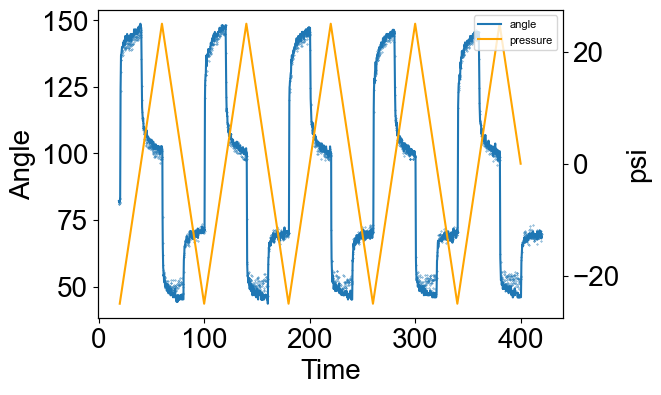

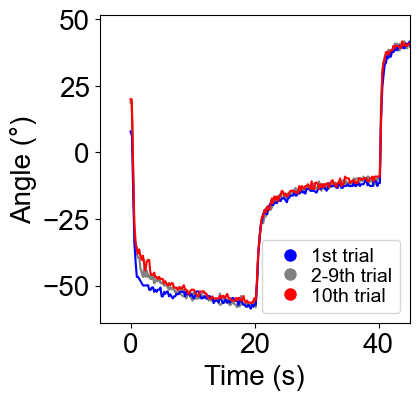

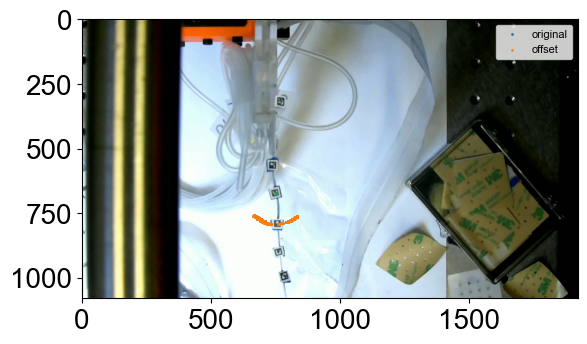

In [240]:
plot_step_response(1, 1, 5, result_name_arr, tag_offset_dict, ids, values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)

In [241]:
def plot_step_response(index_of_tag, index_of_actuator, n_cycle, result_name_arr, tag_offset_dict, ids, values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr):
    plt.rcParams['font.size'] = fontsize_main
    tag_of_desired = tag_mapping[index_of_tag]
    base_angle = 87

    lines = []
    lines_circle = []
    fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
    fig, ax_img = plt.subplots()
    fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

    img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
    ax_img.imshow(img)

    for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
        
        # print(calc_angle_wrt_horiz(camera_data_dict['corners'][tag_of_desired][0]))    
        # r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
        # r_time = times_dict[regulator_mapping[index_of_actuator][0]]
        # ax = ax_ori
        # #ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
        # ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], linestyle='-', label = "angle") # plotting angle vs time
        # ax.set_xlabel('Time')
        # ax.set_ylabel('Angle')
        # #ax.legend()
        # ax1 = ax.twinx()
        # ax1.plot(r_time, r_val, color = "green", label = "psi") # ploting pressure vs time
        # ax1.set_ylabel('psi')
        # #ax1.legend()

        # cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
        
        # ax = ax_img
        # ax.scatter(
        #         camera_data_dict['centroid'][tag_of_desired][:, 0], 
        #         camera_data_dict['centroid'][tag_of_desired][:, 1], 
        #         linestyle='-',
        #         # label=f'Trial {i+1}',
        #         s=1,
        #         color = "orange",
        #         label = "original"
        #     )
        # if tag_of_desired in tag_offset_dict:
        #     ax.scatter(
        #             camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
        #             camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
        #             linestyle='-',
        #             # label=f'Trial {i+1}',
        #             s=1,
        #             color = "blue",
        #             label = "offset"
        #         )
        # ax.legend()
        r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
        r_time = times_dict[regulator_mapping[index_of_actuator][0]]

        ax = ax_img
        ax.scatter(
                camera_data_dict['centroid'][tag_of_desired][:, 0], 
                camera_data_dict['centroid'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "original"
            )
        if tag_of_desired in tag_offset_dict:
            ax.scatter(
                    camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                    camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                    linestyle='-',
                    # label=f'Trial {i+1}',
                    s=1,
                    label = "offset"
                )
        ax.legend(loc = 1, prop= {"size": 8})
        
        xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
        ax.scatter([xc], [yc], s=2)
        xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
        #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0], xc, yc, r)
        #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))
        ax = ax_ori
        ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
        ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
        ax.set_xlabel('Time')
        ax.set_ylabel('Angle')
        ax1 = ax.twinx()
        ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
        ax1.set_ylabel('psi')

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc = 1, prop={'size': 8})

        xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
        ax.scatter([xc], [yc], s=2)

        angles[angles < -1.5] += 2 * np.pi
        #camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

        print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

        angle_plot_arr = []
        for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
            if i == 0:
                color = 'blue'
            elif i == n_cycle-1:
                color = 'red'
            else:
                color = 'grey'
                
            ax = ax_angle[0]    
            # if i != 0:
                # continue
            start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
            end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

            #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
            angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle)
            angle_plot_arr.append(np.copy(angle_plot))
            if i == 0:
                print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
            #print(t_plot[-10:])
            angle_plot_arr.append(angle_plot)
            line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                    angle_plot, 
                    linestyle='-',
                    label=f'#{i+1}',
                    color=color
                    )
            
            if ii == len(result_name_arr) - 1:
                lines.append(line)

            ax = ax_angle[1]
            start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
            end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

            ax.scatter(
                (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
                camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
                linestyle='-',
                label=f'Trial {i+1}',
                s=1,
                color=color
            )

        # calc_angle_var(angle_plot_arr)
        # lines_circle.append(plot_circle_arc(ax, np.array([0, 0]), r, np.min(angles), np.max(angles), flip_x=False))


        # ax.legend()
    print(lines)
    for i, ax in enumerate([ax_angle[0]]):
        #ax.set_ylim(100,130)
        # ax.set_yticks([0, 25,50,75,100,125])
        # ax.set_yticklabels(['0', '', '50', '','100',''])
        ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
        #map tmime to pressure
        ax.set_xticks([map_range(tmp, -25, 25, 
                                np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                                np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
        ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
        
        # ax.set_title(f'{psi[i]} kPa', fontsize='24')
        # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
        if i == 0:
            ax.set_ylabel('Angle (°)', )
            ax.set_xlabel('Pressure (kPa)', )
        if i == 1:
            legend_labels = [r'1st trial', r'2-9th trial', '10th trial']
            legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
            legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                            labelspacing=0.1, 
                            columnspacing =0.05,
                            loc='lower right', 
                            handletextpad=0.1, 
                            fontsize=fontsize_legend
                            )

    # for i, ax in enumerate([ax_angle[1]]):
    #     # ax.axis('equal')
    #     ax.set_xlim(-7.5, 7.5)
    #     ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #     ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #     ax.set_ylim(0, 7.5)
    #     ax.set_yticks([0, 2.5, 5, 7.5])
    #     ax.set_yticklabels(['0', '', '5', '',])
        
    #     ax.set_aspect('equal')
    #     if i == 0:
    #         ax.set_ylabel('Displacement-Y (mm)')
    #     # if i == 0:
    #     #     ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    #     if i == 0:
    #         ax.set_xlabel('Displacement-X (mm)')

    # fig.text(0.06, 0.5, , va='center', rotation='vertical')
    # plt.tight_layout()

    #plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
    plt.show()